In [6]:
from nilearn.image import load_img
import tqdm

from nilearn import image

from nilearn.masking import apply_mask, unmask
from scipy.spatial.distance import squareform
import bct
from scipy.stats import norm
from statsmodels.stats.multitest import  multipletests
from scipy.stats import ttest_1samp
from scipy.spatial.distance import dice
from seaborn.algorithms import bootstrap

plt.rcParams['font.family'] = ['arial']

final_subjects = np.loadtxt("../data/subjects_intersect_motion_035.txt")
n_subjects = len(final_subjects)
print(n_subjects)

def _percentile_interval(data, width):
    """Return a percentile interval from data of a given width."""
    edge = (100 - width) / 2
    percentiles = edge, 100 - edge
    return np.nanpercentile(data, percentiles)

242


In [2]:
pattern = "../results/first-level/gsr/node_roi/shen/task-stroop/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
stroop_node_ef = np.array([np.squeeze(image.load_img(pattern % subj).get_fdata()) \
                           for subj in final_subjects])

pattern = "../results/first-level/gsr/node_roi/shen/task-msit/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
msit_node_ef = np.array([np.squeeze(image.load_img(pattern % subj).get_fdata()) \
                           for subj in final_subjects])

pattern = "../results/first-level/gsr/edge/shen/task-stroop/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
stroop_edge_ef = []
for subj in final_subjects:
    stroop_edge_data = image.load_img(pattern % subj).get_fdata()
    stroop_edge_data = squareform(np.squeeze(stroop_edge_data), checks=False)
    stroop_edge_ef.append(stroop_edge_data)
stroop_edge_ef = np.array(stroop_edge_ef)

pattern = "../results/first-level/gsr/edge/shen/task-msit/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
msit_edge_ef = []
for subj in final_subjects:
    msit_edge_data = image.load_img(pattern % subj).get_fdata()
    msit_edge_data = squareform(np.squeeze(msit_edge_data), checks=False)
    msit_edge_ef.append(msit_edge_data)
    
msit_edge_ef = np.array(msit_edge_ef)

t_node_stroop, p_node_stroop = np.apply_along_axis(ttest_1samp, axis=0, arr=stroop_node_ef, popmean=0)
t_node_msit, p_node_msit = np.apply_along_axis(ttest_1samp, axis=0, arr=msit_node_ef, popmean=0)

t_edge_stroop, p_edge_stroop = np.apply_along_axis(ttest_1samp, axis=0, arr=stroop_edge_ef, popmean=0)
t_edge_msit, p_edge_msit = np.apply_along_axis(ttest_1samp, axis=0, arr=msit_edge_ef, popmean=0)

In [3]:
# Group level
r, _ = stats.spearmanr(t_node_stroop, t_node_msit)

print("NODE T-similarity: ", r)

r, _ = stats.spearmanr(t_edge_stroop, t_edge_msit)

print("EDGE T-similarity: ", r)

NODE T-similarity:  0.8707556574090409
EDGE T-similarity:  0.6525301683316419


In [4]:
# subject level
sims_node = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_node_ef, msit_node_ef)]
sims_edge = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_edge_ef, msit_edge_ef)]

print(np.mean(sims_node), np.std(sims_node))
print(np.mean(sims_edge), np.std(sims_edge))

0.2996788077668444 0.1715904302104676
0.038460676047938416 0.05936543894959584


In [7]:
print(np.round(np.mean(sims_node),3))
print(np.round(_percentile_interval(bootstrap(sims_node, n_boot=1000, func=np.mean), width=95), 3))

0.3
[0.28  0.321]


In [8]:
print(np.round(np.mean(sims_edge),3))
print(np.round(_percentile_interval(bootstrap(sims_edge, n_boot=1000, func=np.mean), width=95), 3))

0.038
[0.031 0.046]


## Question 1: 

### "What's the similarity between networks if we only concentrate on the subnetwork that higher respond to the task?"

To do this, we concentrate on a subset of regions that are most evoked in both tasks (absolute d's Cohen > 0.8) and compute similarities using just the sub-network from these regions.

In [9]:
# Cohen's d at group level.
abs_d_node_stroop = abs(t_node_stroop)/np.sqrt(242-1)
abs_d_node_msit = abs(t_node_msit)/np.sqrt(242-1)

mask_roi = (abs_d_node_stroop>0.8) & (abs_d_node_msit>0.8)

print(f"# of most evoked regions: {sum(mask_roi)}")

mask_edge = squareform(np.outer(mask_roi, mask_roi), checks=False)

print("NODE similarity (group-level): ", 
      stats.spearmanr(t_node_stroop[mask_roi], t_node_msit[mask_roi])[0])
print("EDGE similarity (group-level): ", 
      stats.spearmanr(t_edge_stroop[mask_edge], t_edge_msit[mask_edge])[0])

sims_node_masked = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_node_ef[:,mask_roi], msit_node_ef[:,mask_roi])]
sims_edge_masked = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_edge_ef[:, mask_edge], msit_edge_ef[:,mask_edge])]

print("NODE similarity (subject-level): ", "mean:", np.mean(sims_node_masked), 
      "sd:", np.std(sims_node_masked))
print("EDGE similarity (subject-level): ",
      "mean:", np.mean(sims_edge_masked), "sd:", np.std(sims_edge_masked))

# of most evoked regions: 21
NODE similarity (group-level):  0.8545454545454545
EDGE similarity (group-level):  0.7293181251275538
NODE similarity (subject-level):  mean: 0.6306268112053236 sd: 0.23674374793104966
EDGE similarity (subject-level):  mean: 0.040829288977979224 sd: 0.133261701919951


<AxesSubplot:xlabel='variable', ylabel='value'>

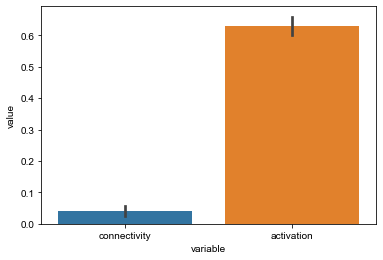

In [10]:
sns.barplot(x='variable', y='value', 
            data=pd.melt(pd.DataFrame({'connectivity':sims_edge_masked, 'activation':sims_node_masked})))

## Question 2: 

### How is between task similarity looking just at the whole-brain connecitivy pattern of each region? I.e. which regions exhibit a similarity rate more comparable to that from node activations?

We will explore the relation between task average node activation and similarity between nodes’ connectivity profiles

In [11]:
n_rois = 268
roiwise_edge_sims  = [stats.spearmanr(squareform(t_edge_stroop)[ii,:][np.arange(n_rois)!=ii],
                                      squareform(t_edge_msit)[ii,:][np.arange(n_rois)!=ii])[0] for ii in range(n_rois)
                     ]
roiwise_edge_sims = np.array(roiwise_edge_sims)

In [12]:
def map_array_atlas(labels_img, data, background_label=0):
    
    from nilearn.image import load_img, new_img_like
    
    labels_image_data = load_img(labels_img).get_fdata()
    # Number of regions excluding the background
    
    labels = np.unique(labels_image_data)
    labels = labels[labels != background_label]
    
    number_of_regions = np.sum(labels != background_label)
    
    new_data = np.zeros_like(labels_image_data)
    
    for label, new_val in zip(labels, data):
        new_data[labels_image_data==label] = new_val
        
    return new_img_like(labels_img, new_data)

In [13]:
from nilearn import plotting

In [14]:
from nilearn.datasets import fetch_atlas_aal
from nilearn.plotting import find_parcellation_cut_coords

she_coords = find_parcellation_cut_coords("../data/atlases/shen_2mm_268_parcellation.nii.gz")


aal_coords = find_parcellation_cut_coords(fetch_atlas_aal()['maps'])
aal_labels = fetch_atlas_aal()['labels']

# For each region of shen, find the closest region in AAL
shen_aal_labels = [aal_labels[np.argmin(np.sum((aal_coords-she_coords[ii,:])**2, axis=1))] 
                   for ii in range(268)]
shen_aal_labels = np.array(shen_aal_labels)

In [15]:
from nilearn.input_data import NiftiLabelsMasker
aal_atlas = load_img(fetch_atlas_aal()['maps'])
aal_atlas.shape

(91, 109, 91)

In [291]:
aal_labels_dict = dict()

for idx, label in zip(fetch_atlas_aal()['indices'], fetch_atlas_aal()['labels']):
    aal_labels_dict[idx] = label
aal_labels_dict['0'] = "Background"

In [288]:
shen_data = load_img(atlas_img).get_fdata()
aal_atlas_data = load_img(fetch_atlas_aal()['maps']).get_fdata()
shen_aal_labels = []
for ii in np.arange(1, 269):
    overlap_regions = aal_atlas_data[shen_data==ii].astype(int)
    shen_aal_labels.append(np.bincount(overlap_regions).argmax())

In [295]:
shen_aal_labels = np.array([aal_labels_dict[str(idx)] for idx in shen_aal_labels])

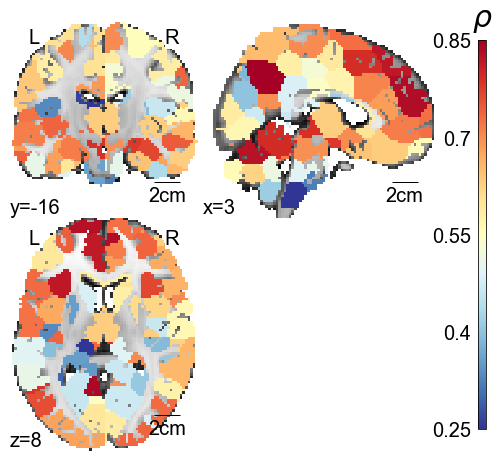

In [246]:
from nilearn.datasets import load_mni152_template
display = plotting.plot_img(map_array_atlas(atlas_img, roiwise_edge_sims), 
                  cmap=plt.cm.RdYlBu_r, 
                  display_mode='tiled', 
                  #cut_coords = (20,0,0),
                  bg_img = load_mni152_template(), 
                  draw_cross=False, black_bg=False,
                  threshold=1e-6, colorbar=True)
display.annotate(size=20, scalebar=True, scale_size=2)
display._colorbar_ax.yaxis.set_tick_params(width=0, labelsize=20)
display._colorbar_ax.set_title(r'$\rho$', {'color':'k', 'fontsize':30}, loc="center", y=1.02)
display.savefig("../plots/supplementary/regionwise_sims_map.svg", dpi=300)
display.savefig("../plots/supplementary/regionwise_sims_map.png", dpi=300)
display.savefig("../plots/supplementary/regionwise_sims_map.pdf", dpi=300)

Text(0.5, 1.02, '$\\rho$')

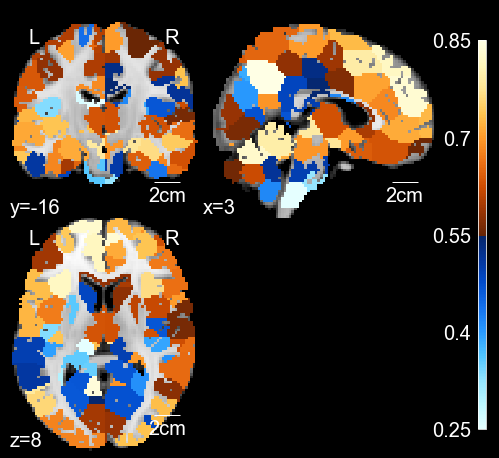

In [247]:
from nilearn.datasets import load_mni152_template
display = plotting.plot_img(map_array_atlas(atlas_img, roiwise_edge_sims), 
                  cmap=plotting.cm.cyan_orange, 
                  display_mode='tiled', 
                  #cut_coords = (20,0,0),
                  bg_img = load_mni152_template(), 
                  draw_cross=False, black_bg=True,
                  threshold=1e-6, colorbar=True)
display.annotate(size=20, scalebar=True, scale_size=2)
display._colorbar_ax.yaxis.set_tick_params(width=0, labelsize=20)
display._colorbar_ax.set_title(r'$\rho$', {'color':'k', 'fontsize':30}, loc="center", y=1.02)
#display.savefig("../plots/supplementary/regionwise_sims_map.svg", dpi=300)
#display.savefig("../plots/supplementary/regionwise_sims_map.png", dpi=300)
#display.savefig("../plots/supplementary/regionwise_sims_map.pdf", dpi=300)

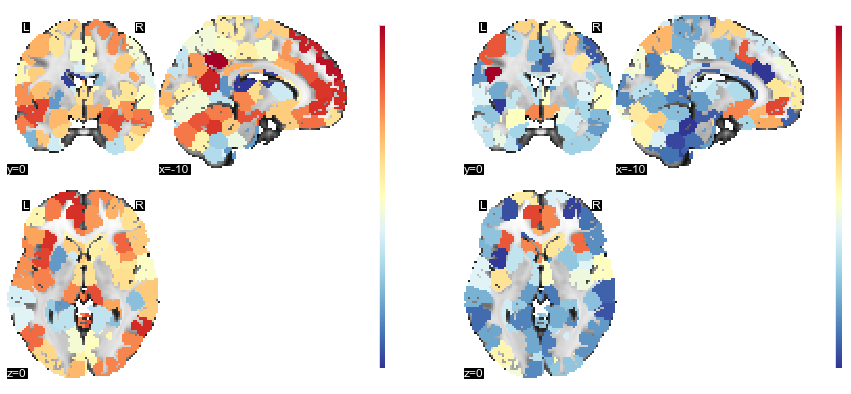

In [307]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 7))
plotting.plot_img(map_array_atlas(atlas_img, roiwise_edge_sims),
                  cmap=plt.cm.RdYlBu_r,
                  cut_coords=(-10, 0,0),
                  display_mode='tiled', 
                  bg_img = load_mni152_template(), 
                  draw_cross=False, black_bg=True,
                  threshold=1e-6, colorbar=True, axes=axs[0])

plotting.plot_img(map_array_atlas(atlas_img, (np.mean([abs_d_node_stroop, abs_d_node_msit], axis=0))),
                  cmap=plt.cm.RdYlBu_r, 
                  cut_coords=(-10, 0,0),
                  display_mode='tiled', 
                  bg_img = load_mni152_template(), 
                  draw_cross=False, black_bg=True,
                  threshold=1e-6, colorbar=True, axes=axs[1])

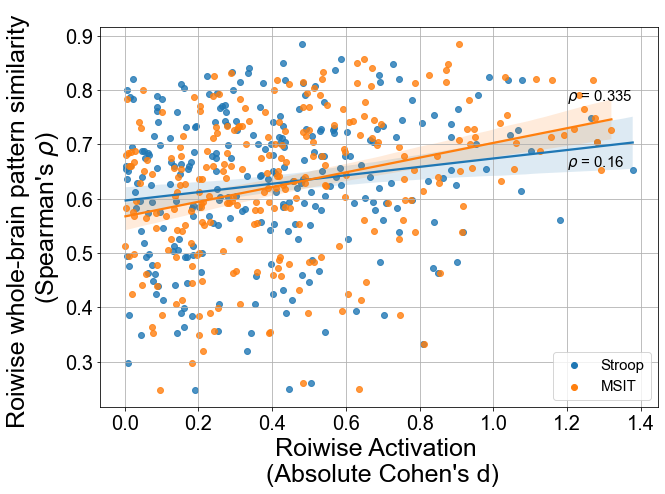

In [92]:
fig, ax = plt.subplots(figsize=(10,7))
sns.regplot(x='activation', y='rois_edge_sim', 
    data=pd.DataFrame({'rois_edge_sim':roiwise_edge_sims, 'activation':abs_d_node_stroop}), ax=ax)
sns.regplot(x='activation', y='rois_edge_sim', 
    data=pd.DataFrame({'rois_edge_sim':roiwise_edge_sims, 'activation':abs_d_node_msit}), ax=ax)

ax.tick_params(labelsize=20)
ax.set_xlabel("Roiwise Activation \n (Absolute Cohen's d)", size=25)
ax.set_ylabel("Roiwise whole-brain pattern similarity \n" + r"(Spearman's $\rho$)", size=25)
ax.annotate(r"$\rho$ = "f"{np.round(stats.spearmanr(roiwise_edge_sims, abs_d_node_stroop)[0], 3)}", 
            xy=[1.2, 0.66], size=15)
ax.annotate(r"$\rho$ = "f"{np.round(stats.spearmanr(roiwise_edge_sims, abs_d_node_msit)[0], 3)}", 
            xy=[1.2, 0.78], size=15)

sns.scatterplot(x='value', y='rois_edge_sim', hue='variable', 
    data=pd.melt(pd.DataFrame({'rois_edge_sim':roiwise_edge_sims, 
                               'Stroop':abs_d_node_stroop,
                               'MSIT':abs_d_node_msit}), 
                 id_vars=['rois_edge_sim']),
                alpha=0, ax=ax)
plt.legend(loc='lower right', fontsize=15)
ax.grid()

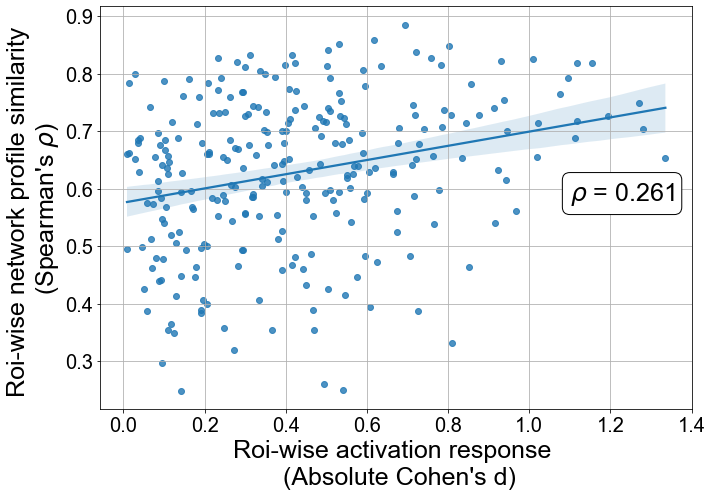

In [269]:
fig, ax = plt.subplots(figsize=(10,7))
sns.regplot(x='activation', y='rois_edge_sim', 
    data=pd.DataFrame({'rois_edge_sim':roiwise_edge_sims, 
                       'activation':np.mean([abs_d_node_stroop, abs_d_node_msit], axis=0)}), ax=ax)
ax.tick_params(labelsize=20)
ax.set_xlabel("Roi-wise activation response \n (Absolute Cohen's d)", size=25)
ax.set_ylabel("Roi-wise network profile similarity \n" + r"(Spearman's $\rho$)", size=25)
rho = stats.spearmanr(roiwise_edge_sims, np.mean([abs_d_node_stroop, abs_d_node_msit], axis=0))[0]
ax.annotate(r"$\rho$ = "f"{np.round(rho,3)}", 
            xy=[1.1, 0.58], 
            size=25, bbox = dict(boxstyle="round", fc="1.0", alpha=1) )
ax.grid()
plt.tight_layout()
plt.savefig("../plots/supplementary/regionwise_sims_vs_activations_scatter.svg", dpi=300)
plt.savefig("../plots/supplementary/regionwise_sims_vs_activations_scatter.png", dpi=300)
plt.savefig("../plots/supplementary/regionwise_sims_vs_activations_scatter.pdf", dpi=300)

### Question 3:

## We will explore the relation between-task distances at the region level, using on one hand the absolute difference in activation and on the other, the euclidean or correlation distance between connectivity profiles. Therefore, this will address whether regions with more similar activation values between tasks are also more similar using their connectivity profiles?

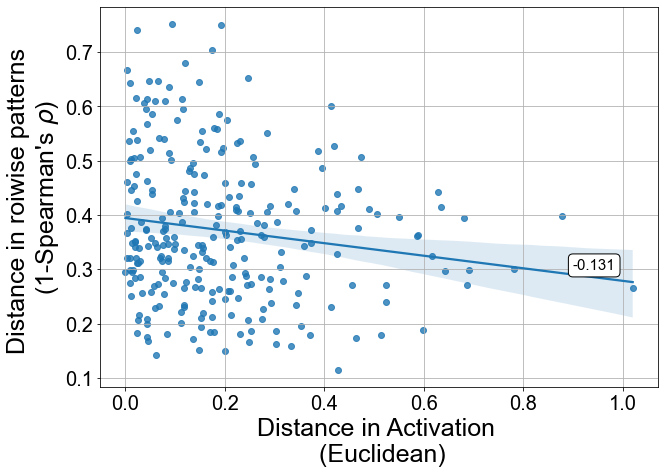

In [17]:
fig, ax = plt.subplots(figsize=(10,7))
sns.regplot(x='distance_nodes', y='distance_edges', 
    data=pd.DataFrame({'distance_edges':1-roiwise_edge_sims, 
                       'distance_nodes':abs(t_node_stroop - t_node_msit)/np.sqrt(242-1)}), ax=ax)
ax.tick_params(labelsize=20)
ax.set_xlabel("Distance in Activation \n (Euclidean)", size=25)
ax.set_ylabel("Distance in roiwise patterns \n" + r"(1-Spearman's $\rho$)", size=25)
ax.annotate(np.round(stats.spearmanr(1-roiwise_edge_sims, 
                                     abs(t_node_stroop - t_node_msit)/np.sqrt(242-1))[0], 3), 
            xy=[0.9, 0.3], size=15, bbox = dict(boxstyle="round", fc="1.0"))
ax.grid()

# Comparison of similarity rates with task conditions included

In [16]:
pattern = "../results/first-level/edge_gsr_w_tasks/shen/task-stroop/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
stroop_edge_ef_wtasks = []
for subj in final_subjects:
    stroop_edge_data = image.load_img(pattern % subj).get_fdata()
    stroop_edge_data = squareform(np.squeeze(stroop_edge_data), checks=False)
    stroop_edge_ef_wtasks.append(stroop_edge_data)
stroop_edge_ef_wtasks = np.array(stroop_edge_ef_wtasks)

pattern = "../results/first-level/edge_gsr_w_tasks/shen/task-msit/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
msit_edge_ef_wtasks = []
for subj in final_subjects:
    msit_edge_data = image.load_img(pattern % subj).get_fdata()
    msit_edge_data = squareform(np.squeeze(msit_edge_data), checks=False)
    msit_edge_ef_wtasks.append(msit_edge_data)
    
msit_edge_ef_wtasks = np.array(msit_edge_ef_wtasks)

sims_edge_wtasks = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_edge_ef_wtasks, msit_edge_ef_wtasks)]

In [17]:
print(np.round(np.mean(sims_edge_wtasks),3))
print(np.round(_percentile_interval(bootstrap(sims_edge_wtasks, n_boot=1000, func=np.mean), width=95), 3))

0.075
[0.067 0.083]


In [18]:
import dabest
dabest.load(pd.DataFrame({'activation': sims_node, 'FC': sims_edge_wtasks, 
                          'id':np.arange(len(sims_edge))}), 
            idx = ("activation", "FC"), id_col='id', paired=True).cohens_d.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,activation,FC,242,242,Cohen's d,True,-1.719179,95,-1.919651,-1.493666,0.0,1.250550e-37,725.0,5.013799e-61,22.460245


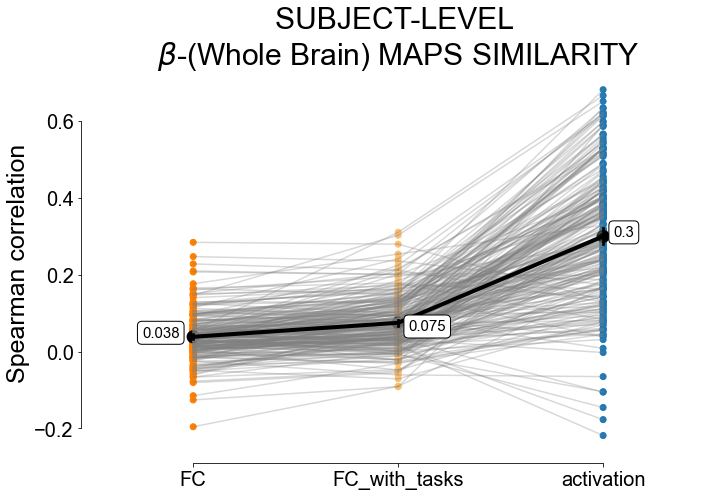

In [19]:
fig, ax= plt.subplots(figsize=(10,7))

for x,y, z in zip(sims_edge, sims_edge_wtasks, sims_node):
    ax.scatter([0,1, 2], [x, y, z], c=[sns.color_palette("Paired")[7], 
                                  sns.color_palette("Paired")[6], sns.color_palette("Paired")[1]])
    
    ax.plot([0,1], [x, y], color="grey", alpha=0.3)
    ax.plot([1,2], [y, z], color="grey", alpha=0.3)

sns.pointplot(x="variable", y="value", 
              scale=1.5,
              data=pd.melt(pd.DataFrame({'FC':sims_edge, 
                                         'FC_with_tasks':sims_edge_wtasks, 
                                         'activation': sims_node})), 
              color='black',
              ax=ax)
ax.set_ylabel("Spearman correlation", size=25)
ax.set_xlabel("")
ax.tick_params(labelsize=20)
ax.set_title("SUBJECT-LEVEL \n" + r"$\beta$-(Whole Brain) MAPS SIMILARITY", size=30)
ax.annotate(np.round(np.mean(sims_edge), 3), xy=[-0.25, np.mean(sims_edge)], size=15, 
            bbox = dict(boxstyle="round", fc="1.0"))
ax.annotate(np.round(np.mean(sims_edge_wtasks), 3), xy=[1.05, np.mean(sims_edge_wtasks)-0.02], 
            size=15, bbox = dict(boxstyle="round", fc="1.0"))
ax.annotate(np.round(np.mean(sims_node), 3), xy=[2.05, np.mean(sims_node)], size=15, 
           bbox = dict(boxstyle="round", fc="1.0"))

sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig("../plots/supplementary/subject_sims_w_tasks.svg", dpi=300)
plt.savefig("../plots/supplementary/subject_sims_w_tasks.png", dpi=300)
plt.savefig("../plots/supplementary/subject_sims_w_tasks.pdf", dpi=300)

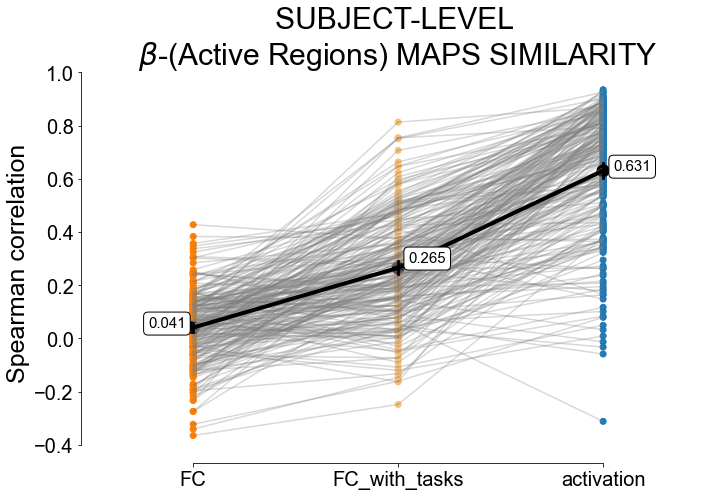

In [20]:
fig, ax= plt.subplots(figsize=(10,7))

sims_edge_masked = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_edge_ef[:,mask_edge], 
                                                            msit_edge_ef[:,mask_edge])]
sims_edge_wtasks_masked = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_edge_ef_wtasks[:,mask_edge], 
                                                                   msit_edge_ef_wtasks[:,mask_edge])]

for x,y,z in zip(sims_edge_masked, sims_edge_wtasks_masked, sims_node_masked):
    ax.scatter([0,1,2], [x, y, z], c=[sns.color_palette("Paired")[7], 
                                      sns.color_palette("Paired")[6], 
                                      sns.color_palette("Paired")[1]])
    
    ax.plot([0,1], [x, y], color="grey", alpha=0.3)
    ax.plot([1,2], [y, z], color="grey", alpha=0.3)

sns.pointplot(x="variable", y="value", 
              scale=1.5,
              data=pd.melt(
                  pd.DataFrame(
                  {'FC':sims_edge_masked,
                   'FC_with_tasks':sims_edge_wtasks_masked,
                  'activation': sims_node_masked})), 
              color='black',
              ax=ax)
ax.set_ylabel("Spearman correlation", size=25)
#ax.set_xticklabels(["Activation", "Connectivity"], size=20)
ax.set_xlabel("")
ax.annotate(np.round(np.mean(sims_edge_masked), 3), xy=[-0.22, np.mean(sims_edge_masked)], size=15, 
           bbox = dict(boxstyle="round", fc="1.0"))
ax.annotate(np.round(np.mean(sims_edge_wtasks_masked), 3), 
            xy=[1.05, np.mean(sims_edge_wtasks_masked)+0.02], 
            bbox = dict(boxstyle="round", fc="1.0"),
            size=15)
ax.annotate(np.round(np.mean(sims_node_masked), 3), xy=[2.05, np.mean(sims_node_masked)], size=15,
           bbox = dict(boxstyle="round", fc="1.0"))
ax.tick_params(labelsize=20)
ax.set_title("SUBJECT-LEVEL \n" + r"$\beta$-(Active Regions) MAPS SIMILARITY", size=30)
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig("../plots/supplementary/subject_sims_w_tasks_actregs.svg", dpi=300)
plt.savefig("../plots/supplementary/subject_sims_w_tasks_actregs.png", dpi=300)
plt.savefig("../plots/supplementary/subject_sims_w_tasks_actregs.pdf", dpi=300)

# Differences between different parcellations

In [21]:
stroop_node_ef_dict = dict()
msit_node_ef_dict = dict()
stroop_edge_ef_dict = dict()
msit_edge_ef_dict = dict()

for atlas_name in ["shen", "craddock", "schaefer"]:
    pattern = f"../results/first-level/gsr/node_roi/{atlas_name}/task-stroop/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
    stroop_node_ef = np.array([np.squeeze(image.load_img(pattern % subj).get_fdata()) \
                               for subj in final_subjects])
    stroop_node_ef_dict[atlas_name] = stroop_node_ef

    pattern = f"../results/first-level/gsr/node_roi/{atlas_name}/task-msit/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
    msit_node_ef = np.array([np.squeeze(image.load_img(pattern % subj).get_fdata()) \
                               for subj in final_subjects])
    msit_node_ef_dict[atlas_name] = msit_node_ef
    
    pattern = f"../results/first-level/gsr/edge/{atlas_name}/task-stroop/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
    stroop_edge_ef = []
    for subj in final_subjects:
        stroop_edge_data = image.load_img(pattern % subj).get_fdata()
        stroop_edge_data = squareform(np.squeeze(stroop_edge_data), checks=False)
        stroop_edge_ef.append(stroop_edge_data)
    stroop_edge_ef_dict[atlas_name] = np.array(stroop_edge_ef)
    
    pattern = f"../results/first-level/gsr/edge/{atlas_name}/task-msit/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
    msit_edge_ef = []
    for subj in final_subjects:
        msit_edge_data = image.load_img(pattern % subj).get_fdata()
        msit_edge_data = squareform(np.squeeze(msit_edge_data), checks=False)
        msit_edge_ef.append(msit_edge_data)

    msit_edge_ef_dict[atlas_name] = np.array(msit_edge_ef)

In [22]:
# atlas-wise subject level sims
sims_node_dict = dict()
sims_edge_dict = dict()

for atlas_name in ["shen", "craddock", "schaefer"]:
 
    sims_node_dict[atlas_name] = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_node_ef_dict[atlas_name], 
                                                                          msit_node_ef_dict[atlas_name])]
    sims_edge_dict[atlas_name] = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_edge_ef_dict[atlas_name], 
                                                                          msit_edge_ef_dict[atlas_name])]

In [23]:
for atlas_name in ["shen", "craddock", "schaefer"]:
    print(atlas_name, "NODE", np.mean(sims_node_dict[atlas_name]))
    print(atlas_name, "EDGE", np.mean(sims_edge_dict[atlas_name]), np.std(sims_edge_dict[atlas_name]))

shen NODE 0.2996788077668444
shen EDGE 0.038460676047938416 0.05936543894959584
craddock NODE 0.35963779673004226
craddock EDGE 0.05110659549501477 0.07580400266542082
schaefer NODE 0.3434040623742867
schaefer EDGE 0.05582838145014686 0.07603876567562234


In [24]:
thr1 = 0.05
thr2 = 0.0005
thr3 = 0.000005
for atlas_name in ["shen", "craddock", "schaefer"]:
    
    
    t_node_stroop, p_node_stroop = np.apply_along_axis(ttest_1samp, 
                                                       axis=0, 
                                                       arr=stroop_node_ef_dict[atlas_name], 
                                                       popmean=0)
    t_node_msit, p_node_msit = np.apply_along_axis(ttest_1samp, 
                                                   axis=0, 
                                                   arr=msit_node_ef_dict[atlas_name], 
                                                   popmean=0)

    t_edge_stroop, p_edge_stroop = np.apply_along_axis(ttest_1samp, 
                                                       axis=0, 
                                                       arr=stroop_edge_ef_dict[atlas_name], 
                                                       popmean=0)
    t_edge_msit, p_edge_msit = np.apply_along_axis(ttest_1samp, 
                                                   axis=0, 
                                                   arr=msit_edge_ef_dict[atlas_name], 
                                                   popmean=0)
    print(f"GROUP-LEVEL ATLAS:{atlas_name}")
    r, _ = stats.spearmanr(t_node_stroop, t_node_msit)
    
    dsc1 = 1-dice(p_node_stroop<thr1, p_node_msit<thr1)
    dsc2 = 1-dice(p_node_stroop<thr2, p_node_msit<thr2)
    dsc3 = 1-dice(p_node_stroop<thr3, p_node_msit<thr3)
    
    print("NODE T-similarity: ", r, "DSC:", [dsc1, dsc2, dsc3])
    
    r, _ = stats.spearmanr(t_edge_stroop, t_edge_msit)
    dsc1 = 1-dice(p_edge_stroop<thr1, p_edge_msit<thr1)
    dsc2 = 1-dice(p_edge_stroop<thr2, p_edge_msit<thr2)
    dsc3 = 1-dice(p_edge_stroop<thr3, p_edge_msit<thr3)
    
    print("EDGE T-similarity: r", r, "DSC:", "DSC:", [dsc1, dsc2, dsc3])
    print("")

GROUP-LEVEL ATLAS:shen
NODE T-similarity:  0.8707556574090409 DSC: [0.8898876404494382, 0.8633879781420765, 0.821656050955414]
EDGE T-similarity: r 0.6525301683316419 DSC: DSC: [0.5439613935571266, 0.45175683212493023, 0.4121983914209115]

GROUP-LEVEL ATLAS:craddock
NODE T-similarity:  0.8848811220280509 DSC: [0.8855421686746988, 0.8338983050847457, 0.8106060606060606]
EDGE T-similarity: r 0.7210848567904024 DSC: DSC: [0.616764652403176, 0.5015045135406219, 0.46755162241887904]

GROUP-LEVEL ATLAS:schaefer
NODE T-similarity:  0.8287392184804621 DSC: [0.8680351906158358, 0.8135593220338984, 0.7709923664122138]
EDGE T-similarity: r 0.7117650718941699 DSC: DSC: [0.6099952741020793, 0.5423825074542099, 0.5111607142857143]



In [25]:
sims_node_df = pd.DataFrame(sims_node_dict)
sims_node_df['measure'] = "activation"

sims_edge_df = pd.DataFrame(sims_edge_dict)
sims_edge_df['measure'] = "FC"

sims_both_df = pd.concat([sims_node_df, sims_edge_df], axis=0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


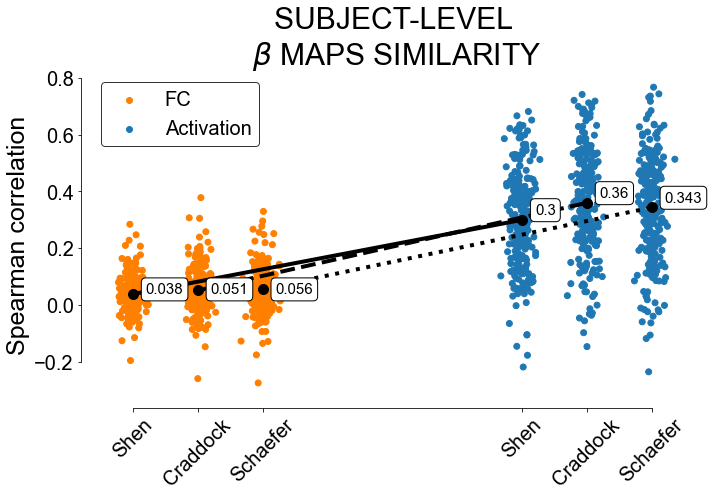

In [27]:
fig, ax= plt.subplots(figsize=(10,7))

for tick, lt, atlas_name in zip([-0.05,0,0.05],
                                ['-', "--", ":"],
                            ["shen", "craddock", "schaefer"]):
    for x,y in zip(sims_edge_dict[atlas_name], sims_node_dict[atlas_name]):
        ax.scatter([0+tick + np.random.normal(loc=0, scale=0.005), 
                    0.3+tick + np.random.normal(loc=0, scale=0.005)], 
                   [x, y], c=[sns.color_palette("Paired")[7], 
                              sns.color_palette("Paired")[1]])
        
        #ax.plot([0+tick, 0.3+tick], [x, y], color="grey", alpha=0.1)
    
    mu_edge = np.mean(sims_edge_dict[atlas_name])
    cis_edge = _percentile_interval(bootstrap(sims_edge_dict[atlas_name], n_boot=1000, func=np.mean), 
                               width=95)
    
    mu_node = np.mean(sims_node_dict[atlas_name])
    cis_node = _percentile_interval(bootstrap(sims_node_dict[atlas_name], n_boot=1000, func=np.mean), 
                               width=95)
    
    ax.scatter([0+tick, 0.3+tick], [mu_edge, mu_node], 
               c='black', s=100)
    ax.plot([0+tick, 0.3+tick], [mu_edge, mu_node], color="black", linestyle=lt, linewidth=4)
    
    errbar = np.row_stack((abs(cis_edge-mu_edge), abs(cis_node-mu_node)))
    
    , 
    ax.annotate(np.round(np.mean(sims_edge_dict[atlas_name]), 3), 
                xy=[0+tick + 0.01, np.mean(sims_edge_masked)], 
                size=15, bbox = dict(boxstyle="round", fc="1.0"))
    ax.annotate(np.round(np.mean(sims_node_dict[atlas_name]), 3), 
                xy=[0.3+tick+ 0.01, np.mean(sims_node_dict[atlas_name])+0.02], 
            size=15, bbox = dict(boxstyle="round", fc="1.0"))

    
ax.set_xticks([-0.05,0, 0.05, 0.25,0.3,0.35])
ax.set_xticklabels(["Shen", "Craddock", "Schaefer"] + ["Shen", "Craddock", "Schaefer"])
sns.despine(offset=10, trim=True)
ax.tick_params(axis='x', labelsize=20, labelrotation=45)
ax.tick_params(axis='y', labelsize=20)
ax.set_title("SUBJECT-LEVEL \n" + r"$\beta$ MAPS SIMILARITY", size=30)
ax.set_ylabel("Spearman correlation", size=25)
plt.scatter(0, x, c = sns.color_palette("Paired")[7], label="FC")
plt.scatter(0.3, y, c = sns.color_palette("Paired")[1], label="Activation")
plt.legend(fontsize=20, edgecolor='k')
plt.tight_layout()
plt.savefig("../plots/supplementary/subject_sims_atlases.svg", dpi=300)
plt.savefig("../plots/supplementary/subject_sims_atlases.png", dpi=300)
plt.savefig("../plots/supplementary/subject_sims_atlases.pdf", dpi=300)